# Experiment 3 - Resnet18 with Triplet Loss

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

import sklearn
from sklearn.neighbors import KNeighborsClassifier

import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import Flowers102
from torchvision.models import resnet18, ResNet18_Weights

import scipy

from tqdm.auto import tqdm

import sys
sys.path.append( "/kaggle/input/utilities" )

from utils_v2 import *

In [2]:
device = torch.device('cuda:0')

# Hyperparameters
BATCH_SIZE = 512
MAX_EPOCHS = 1000
EARLY_STOP = np.inf

criterion = TripletLoss(device=device)

## Training

In [10]:
def do_gc():
    torch._C._cuda_clearCublasWorkspaces()
    torch._dynamo.reset()
    import gc
    gc.collect()
    torch.cuda.empty_cache()

def train(model, train_loader, validation_loader):
    early_stopping_counter = 0
    max_val_acc = 0

    logs = []

    # Adam optimizer
    optimizer = torch.optim.AdamW(model.parameters(), eps=1e-1)    
    # Gradient scaling required for torch AMP (to save GPU memory)
    scaler = torch.cuda.amp.GradScaler()

    do_gc()
    for epoch in tqdm(range(MAX_EPOCHS)):
        total_train_loss = 0
        total_val_loss = 0

        total_train_right = 0
        total_val_right = 0

        # Enables automatic mixed precision to save GPU memory for large batch size required by trpliet loss
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            model.train()
            for X, y in train_loader:
                X, y = X.to(device), y.to(device)

                optimizer.zero_grad()
                y_hat = model(X)
                y_hat = y_hat.to(device)
                loss = criterion(y_hat, y)

                # Perform gradient scaling so the AMP works
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                total_train_loss += loss.detach().cpu().item()

            del X, y
            do_gc()

            train_loss = total_train_loss / len(train_loader)

        # Calculating the validation accuracy.
        # 1. Generate embeddings of the train dataset.
        # 2. Generate embeddings of the validation dataset.
        # 3. Train and score a nearest-neighbour search on the embeddings.
        # Use 1-NN for the reported accuracy.
        model.eval()
        ys = []
        y_hats = []
        for X, y in train_val_loader:
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            ys.append(y.detach().cpu().numpy())
            y_hats.append(y_hat.detach().cpu().numpy())
        train_y = np.concatenate(ys).astype(float)
        train_y_hat = np.concatenate(y_hats).astype(float)

        del X, y
        do_gc()

        ys = []
        y_hats = []
        for X, y in validation_loader:
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            y_hat = y_hat.to(device)
            ys.append(y.detach().cpu().numpy())
            y_hats.append(y_hat.detach().cpu().numpy())

        val_y = np.concatenate(ys).astype(float)
        val_y_hat = np.concatenate(y_hats).astype(float)
        
        del X, y
        do_gc()

        from sklearn.neighbors import KNeighborsClassifier
        nn = KNeighborsClassifier(n_neighbors=1, algorithm='ball_tree')
        nn.fit(train_y_hat, train_y)
        val_acc = nn.score(val_y_hat, val_y)

        print('epoch: {} train loss: {} val acc: {}'.format(
            epoch, train_loss, val_acc))

        unwrapped = model

        if val_acc < max_val_acc:
            early_stopping_counter += 1
        else:
            max_val_acc = val_acc
            early_stopping_counter = 0
            torch.save(unwrapped, '/kaggle/working/{}'.format('best'))

        if early_stopping_counter == EARLY_STOP:
            torch.save(unwrapped, '/kaggle/working/{}'.format(epoch))
            break

        if (epoch+1) % 100 == 0:
            torch.save(unwrapped, '/kaggle/working/{}'.format(epoch))

        torch.save(unwrapped, '/kaggle/working/{}'.format('last'))
        
        logs.append(dict(train_loss=train_loss, val_acc=val_acc))
    
    return logs

In [4]:
# Start with pretrained model without freezing any layers
model = resnet18(weights=ResNet18_Weights.DEFAULT)
# Remove final classification layer, so we produce 2048-dimensional embeddings instead
model.fc = torch.nn.Identity()
model = model.to(device)

train_loader, train_val_loader,  validation_loader, test_loader = get_train_val_test_loader(train_batch_size = BATCH_SIZE, other_batch_size = 100, mixup = False)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 143MB/s] 


100%|██████████| 344862509/344862509 [00:13<00:00, 26373873.76it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 353219.36it/s]


100%|██████████| 14989/14989 [00:00<00:00, 7168577.27it/s]


In [11]:
do_gc()
logs = train(model, train_loader, validation_loader)

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 0 train loss: 0.293212890625 val acc: 0.557843137254902
epoch: 1 train loss: 0.4591064453125 val acc: 0.5813725490196079
epoch: 2 train loss: 0.2259521484375 val acc: 0.5568627450980392
epoch: 3 train loss: 0.16021728515625 val acc: 0.5754901960784313
epoch: 4 train loss: 0.13629150390625 val acc: 0.5794117647058824
epoch: 5 train loss: 0.12164306640625 val acc: 0.6254901960784314
epoch: 6 train loss: 0.104095458984375 val acc: 0.6323529411764706
epoch: 7 train loss: 0.098724365234375 val acc: 0.6735294117647059
epoch: 8 train loss: 0.09686279296875 val acc: 0.6647058823529411
epoch: 9 train loss: 0.093017578125 val acc: 0.6627450980392157
epoch: 10 train loss: 0.077880859375 val acc: 0.6931372549019608
epoch: 11 train loss: 0.0743408203125 val acc: 0.6833333333333333
epoch: 12 train loss: 0.0600433349609375 val acc: 0.7107843137254902
epoch: 13 train loss: 0.062042236328125 val acc: 0.7127450980392157
epoch: 14 train loss: 0.0612335205078125 val acc: 0.7225490196078431
epoch: 1

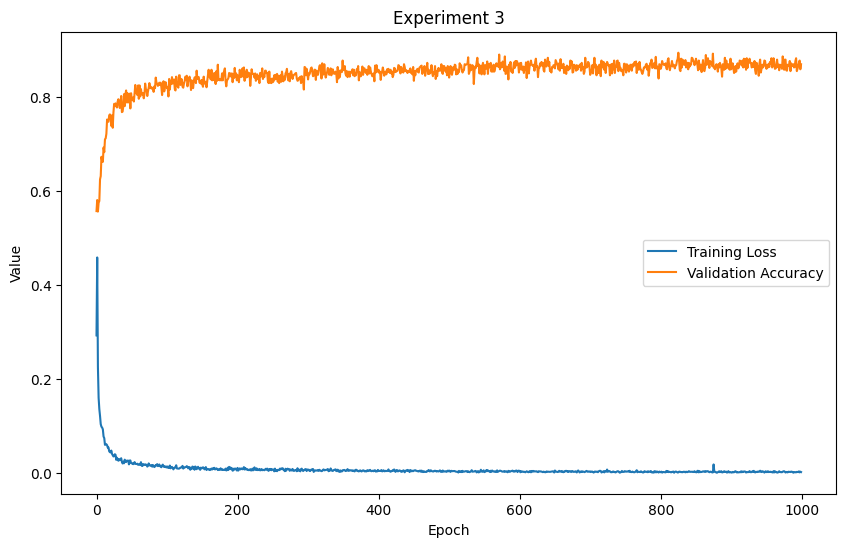

In [22]:
logs_df = pd.DataFrame(logs)
plt.figure(figsize=(10, 6)) 
plt.plot(logs_df['train_loss'], label='Training Loss')
plt.plot(logs_df['val_acc'], label='Validation Accuracy')
plt.title('Experiment 3')  
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()   
plt.show()

## Evaluate the trained model

In [20]:
# Calculating the test accuracy.
# 1. Generate embeddings of the train dataset.
# 2. Generate embeddings of the test dataset.
# 3. Train and score a nearest-neighbour search on the embeddings.
# Use 1-NN for the reported accuracy.

model = torch.load('/kaggle/working/best')

ys = []
y_hats = []
for X, y in tqdm(train_val_loader):
    X, y = X.to(device), y.to(device)
    y_hat = model(X)
    ys.append(y.detach().cpu().numpy())
    y_hats.append(y_hat.detach().cpu().numpy())
train_y = np.concatenate(ys).astype(float)
train_y_hat = np.concatenate(y_hats).astype(float)

del X, y
do_gc()

ys = []
y_hats = []
for X, y in tqdm(test_loader):
    X, y = X.to(device), y.to(device)
    y_hat = model(X)
    y_hat = y_hat.to(device)
    ys.append(y.detach().cpu().numpy())
    y_hats.append(y_hat.detach().cpu().numpy())

test_y = np.concatenate(ys).astype(float)
test_y_hat = np.concatenate(y_hats).astype(float)

del X, y
do_gc()

nn = KNeighborsClassifier(n_neighbors=1, algorithm='ball_tree')
nn.fit(train_y_hat, train_y)
test_acc = nn.score(test_y_hat, test_y)

print("Test accuracy: {}".format(test_acc))

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Val accuracy: 0.8137908603024883


In [17]:
import umap
import umap.plot

2024-04-13 23:00:08.983386: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-13 23:00:08.983488: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-13 23:00:09.122094: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/opt/conda/lib/python3.10

In [18]:
mapper = umap.UMAP().fit(test_y_hat)

<Axes: title={'center': 'Experiment 3'}>

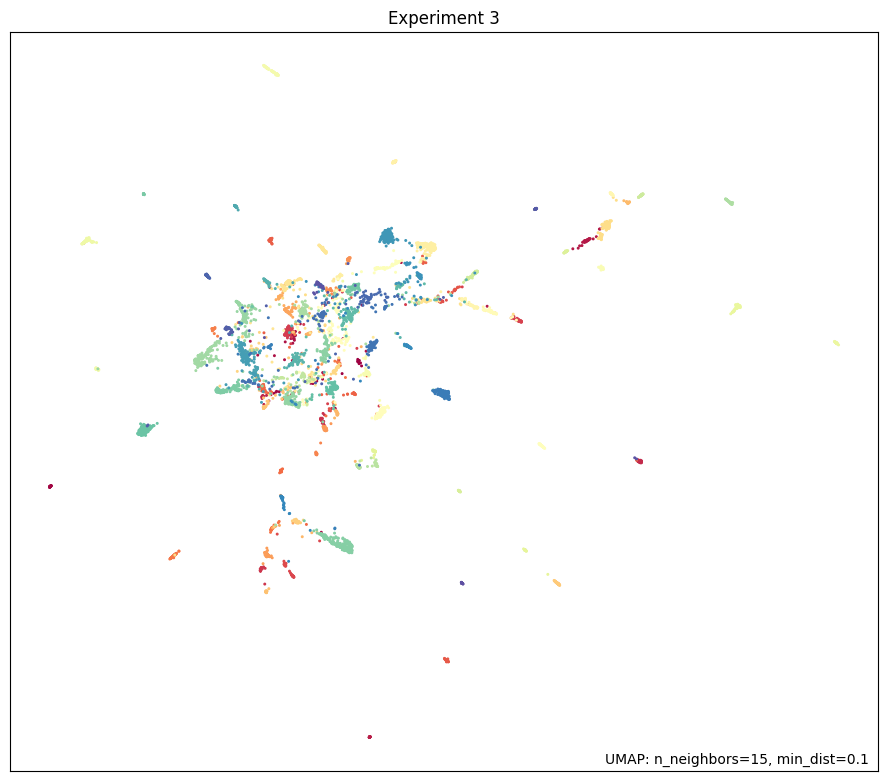

In [23]:
fig, ax = plt.subplots(figsize=(5.6*2, 4.8*2))
plt.title('Experiment 3')
umap.plot.points(mapper, labels=test_y, cmap='viridis', show_legend=False, ax=ax)